<a href="https://colab.research.google.com/github/kundana12345/DataScience/blob/main/KundAddalaU3projKundana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unit 3 Project: The Right Likelihood for the Job

In unit 2, we asked "what's the true proportion of ____?"

In this unit's project, we'll ask "What's the true average of \_\_\_\_?" or "What's the true amount of \_\_\__?"

**Task**:

Two parts:

1. Propose a data set that's compatible with a single variable likelihood from pymc. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one prior, and NONE of your priors can be a beta distribtuion
- Your likelihood CANNOT be a Bernoulli distribution nor a Binomial distribution.



Context: Taiwanese bankruptcy and Return on Assets. In this project I'll be looking at the ROA (Return of Assets) for bankrupt companies in Taiwan. It is a ratio of how profitable a company is relative to its assets. From the data, I took only the bankrupt companies, instead of the ROA values for all the companies, that way we can just look at the values.

In general, lower ROA values mean that a company isn't being effective with their assets, which might show financial distress or inefficency, which could lead to bankruptcy.

Data: https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction

In [ ]:
!pip install "preliz[full,notebook]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Data Science/dataB.csv")
roa = df["ROA"]

In [ ]:
roa

,ROA
0,0.370594
1,0.464291
2,0.426071
3,0.399844
4,0.465022
...,...
6814,0.493687
6815,0.475162
6816,0.472725
6817,0.506264


(array([2.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 1.300e+01, 2.200e+01,
        6.900e+01, 2.070e+02, 6.520e+02, 2.107e+03, 1.574e+03, 5.970e+02,
        1.890e+02, 5.100e+01, 1.800e+01, 4.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.024277  , 0.07306315, 0.1218493 , 0.17063545, 0.2194216 ,
        0.26820775, 0.3169939 , 0.36578005, 0.4145662 , 0.46335235,
        0.5121385 , 0.56092465, 0.6097108 , 0.65849695, 0.7072831 ,
        0.75606925, 0.8048554 , 0.85364155, 0.9024277 , 0.95121385,
        1.        ]),
 <BarContainer object of 20 artists>)

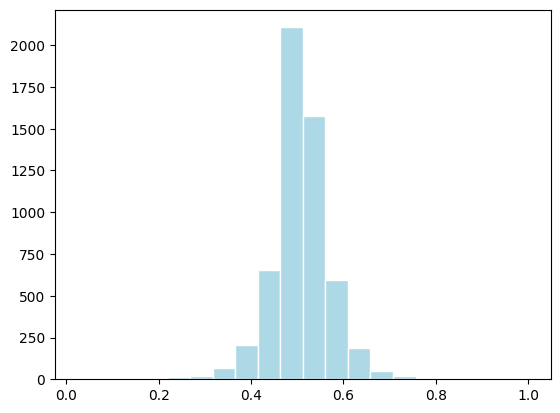

In [ ]:

plt.hist(roa, bins=20, color="lightblue", edgecolor="white") #I did 20 bines to help see the specific data more clearly.


It seems like most bankrupt companies have an ROA between 0.35 and 0.6. The center seems to be near 0.47. The shape looks bell-shaped, maybe Normal and StudentT likelihoods would be a good fit.

Model 1: Normal

We'll have two priors, one for mean and one for spread. The mean ROA we can set μ to be 0.47. We use a Normal distribution because we expect the average ROA to be around 0.47. The standard deviation means that we're somewhat confident but will still allow flexibility.

For the spread, we can use Half Normal so that the standard deviation is positive. The smaller spread values are more likely.

<Axes: >

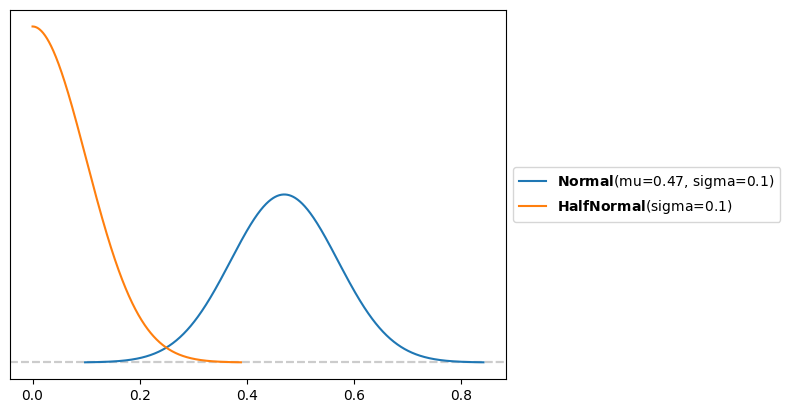

In [ ]:

pz.Normal(mu=0.47, sigma=0.1).plot_pdf()

pz.HalfNormal(sigma=0.1).plot_pdf()

In [ ]:
with pm.Model() as normal_model:
    μ = pm.Normal("μ", mu=0.4, sigma=0.1)
    σ = pm.HalfNormal("σ", sigma=0.1)

    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=roa)
    idata_roa = pm.sample()

/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1300: ImputationWarning: Data in Y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

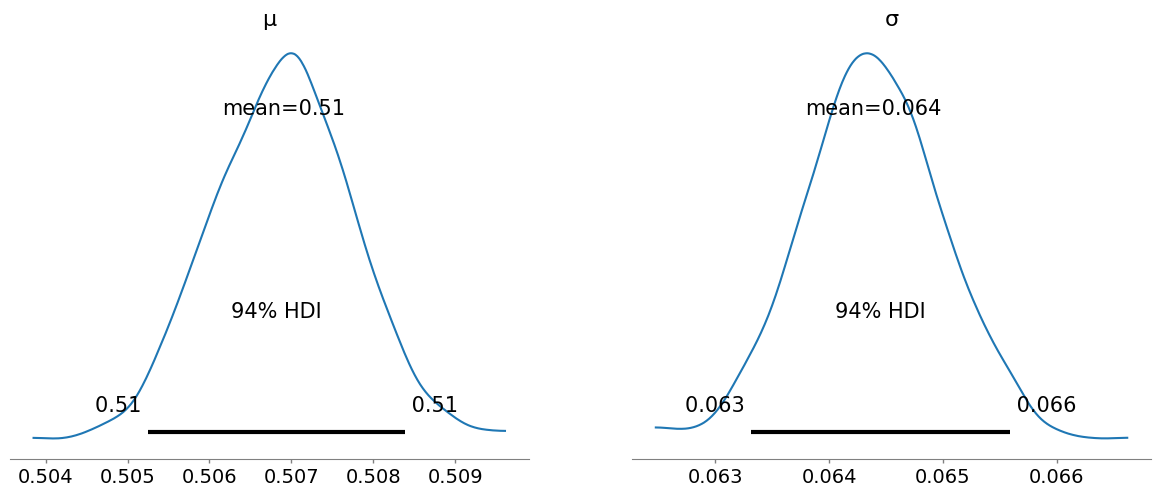

In [ ]:
az.plot_posterior(idata_roa, var_names=["μ", "σ"]) #var_names thing is from chatgpt

In [ ]:
pm.sample_posterior_predictive(idata_roa, model=normal_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y_observed'>

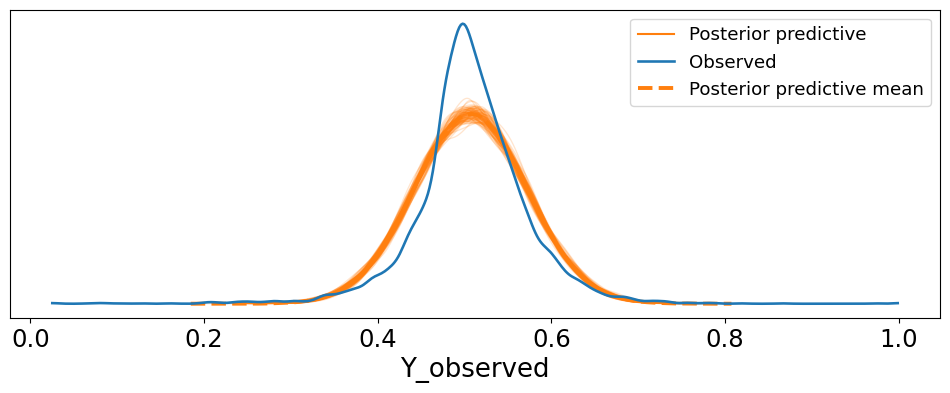

In [ ]:
az.plot_ppc(idata_roa, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Model 1: The blue represents the real data from our sample, and the orange represents what our model thinks the distribution was for ROA. Here, we can see that they have a similar shape, but there is still a gap near the middle (0.5) in the orange and blue lines.

Model 2: StudentT

Priors:
The reasons for the Normal and HalfNormal are the same as Model 1.
The prior for the v shows the degrees of freedom. The exponential gives more weight to smaller values of v, a smaller v means heavier tails, which is good for financial data.



<Axes: >

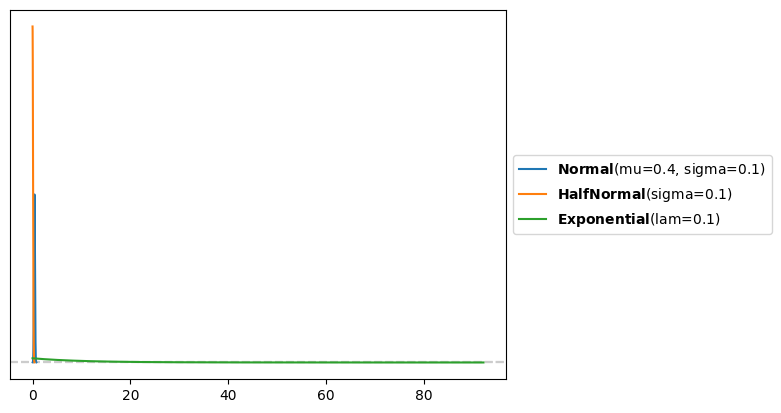

In [ ]:
pz.Normal(mu=0.4, sigma=0.1).plot_pdf()


pz.HalfNormal(sigma=0.1).plot_pdf()


pz.Exponential(lam=1/10).plot_pdf()



The Student-t distribution is similar to the Normal distribution, but it has heavier tailsm so it allows for more extreme values in the data.

In [ ]:
with pm.Model() as student_model:
    mu = pm.Normal("mu", mu=0.4, sigma=0.1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    nu = pm.Exponential("nu", lam=1/10)

    Y = pm.StudentT("roa_obs", nu=nu, mu=mu, sigma=sigma, observed=roa)

    idata_roa = pm.sample()


/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1300: ImputationWarning: Data in roa_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'nu'}>], dtype=object)

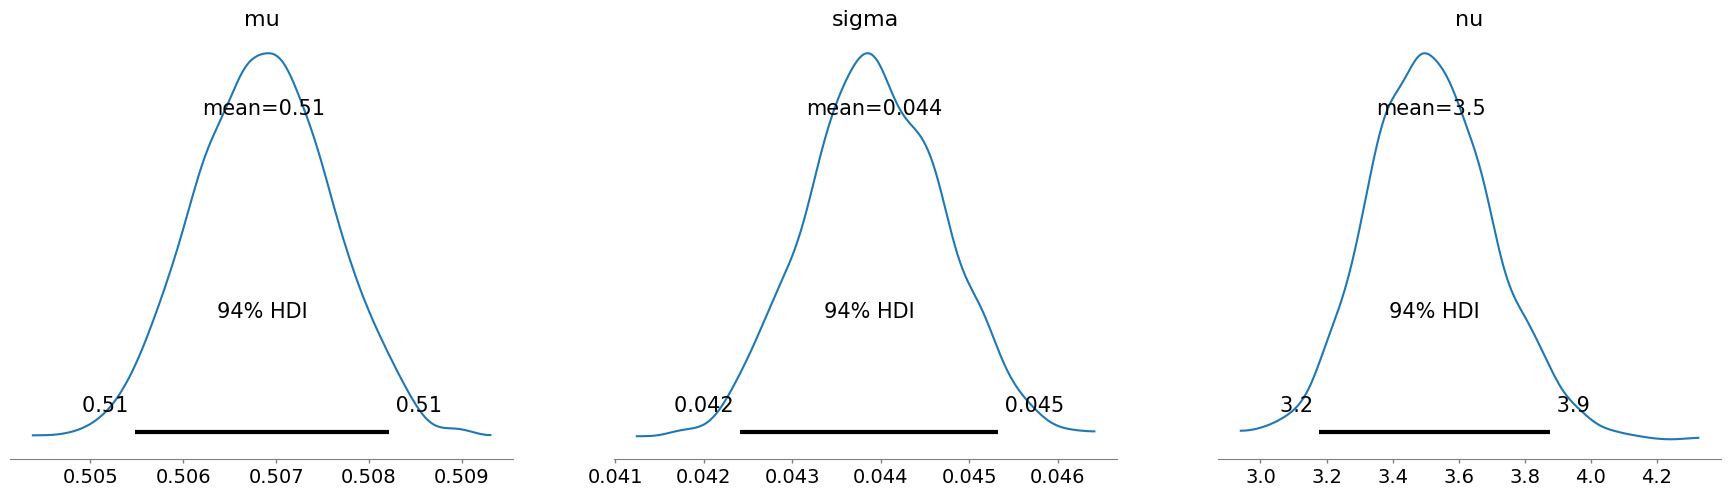

In [ ]:


az.plot_posterior(idata_roa, var_names=["mu", "sigma", "nu"]) #again, var_names thing is from chatgpt



These are the priors for model 2.

In [ ]:
pm.sample_posterior_predictive(idata_roa, model=student_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='roa_obs_observed'>

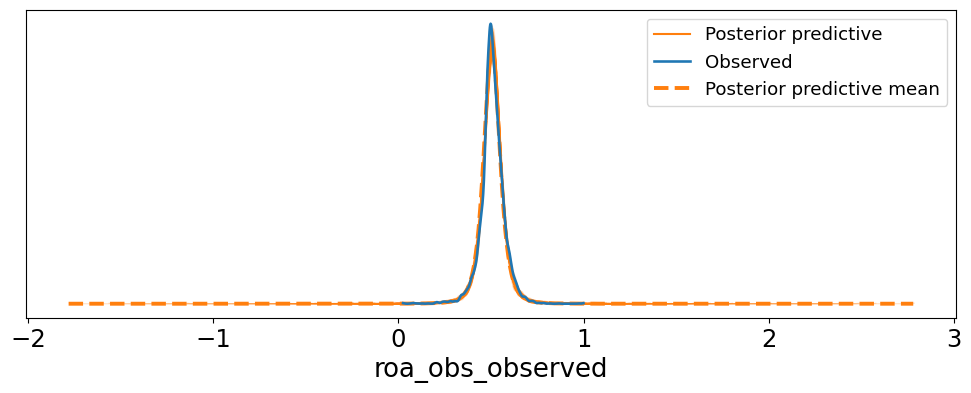

In [ ]:
az.plot_ppc(idata_roa, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The Student-T model may have performed better because it is more robust to outliers and doesn't over react to unusual ROA values.

Guidlines:

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- Want an example? The chemshift data anlysis portion of the Unit3NotesAK is your example. You are expected to be somewhere between a half and three-quarters as detailed--but more is always welcome.

- A posterior predictive check is more important than the posterior for this project. Ask me if you want to know why.

- I didn't totally understand the chemical shift context--which means you don't have to totally understand the context of your data either! You should try to learn as you go, though.
